In [1]:
!pip3 install tqdm
!pip3 install pillow --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 165.0 MB/s  0:00:00
  Attempting uninstall: pillow
    Found existing installation: pillow 11.3.0
    Uninstalling pillow-11.3.0:
      Successfully uninstalled pillow-11.3.0


In [2]:
%matplotlib inline

import os
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [ ]:
# Visualize Data

In [3]:
trimaps_dir = 'data/annotations/trimaps/'

maps = [x for x in os.listdir(trimaps_dir) if x[-3:] == 'png']
print(len(maps))

14780


In [4]:
image_dir = 'data/images/'

images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

7390


In [5]:
images[0]

'Sphynx_133.jpg'

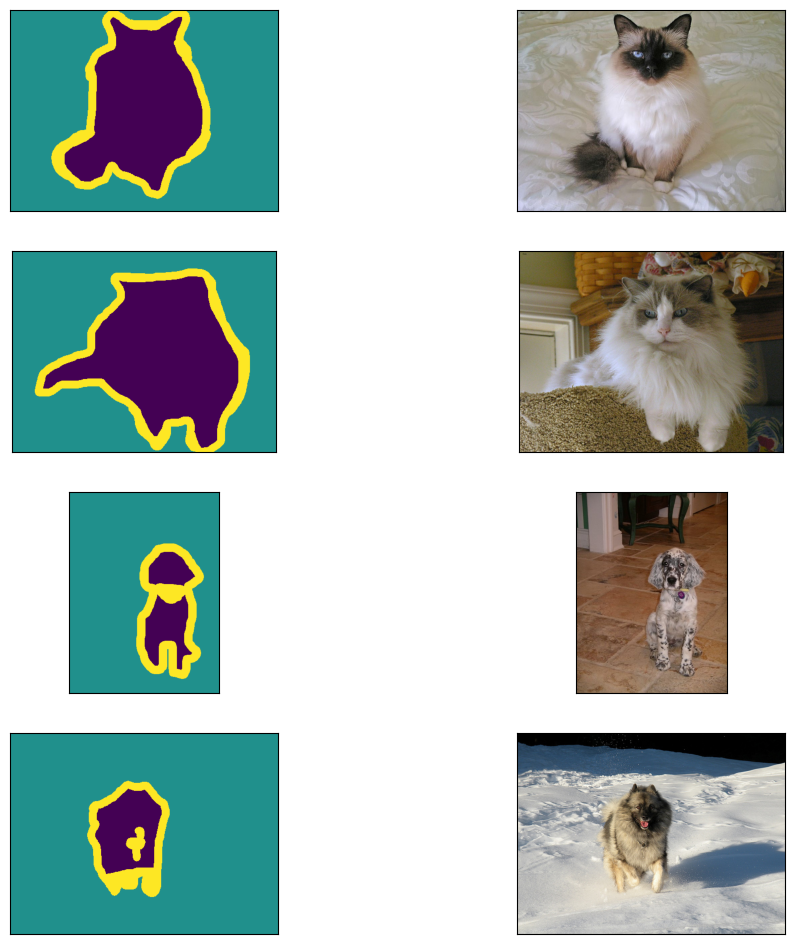

In [6]:
plt.figure(figsize=(12, 12))

for i in range(0, 4):
    index = random.randint(0, len(images) - 1)
    image_name = images[index]
    map_name = images[index].split('.')[0] + '.png'

    plt.subplot(4, 2, 1 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(trimaps_dir, map_name)))
    plt.subplot(4, 2, 2 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(image_dir, image_name)))
plt.show()

In [9]:
img = Image.open(os.path.join(trimaps_dir, maps[1]))
print(np.unique(img))

[1 2 3]


In [10]:
# SageMaker Setup

In [11]:
role = sagemaker.get_execution_role()
bucket_name = 'petsdata'
training_image = get_image_uri(boto3.Session().region_name, 'semantic-segmentation',
                              repo_version='latest')
print(training_image)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


811284229777.dkr.ecr.us-east-1.amazonaws.com/semantic-segmentation:1


In [12]:
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

In [13]:
# Preparing Data for SageMaker

In [14]:
def get_map_file(image):
    map_file = image.split('.')[0] + '.png'
    assert map_file in maps
    return map_file
    
for image in tqdm(images):
    target_set = 'train' if random.randint(0, 99) < 75 else 'validation'
    
    image_file_path = os.path.join('data/images/', image)
    image_target_path = os.path.join(target_set, image)
    
    map_file_path = os.path.join(trimaps_dir, get_map_file(image))
    map_target_path = os.path.join(target_set + '_annotation', get_map_file(image))
    
    shutil.copy(image_file_path, image_target_path)
    shutil.copy(map_file_path, map_target_path)

100%|██████████| 7390/7390 [00:05<00:00, 1445.04it/s]


In [15]:
train_images = os.listdir('train')
train_annots = os.listdir('train_annotation')

In [16]:
print(len(train_annots), len(train_images))

5575 5575


In [17]:
# Uploading Data to S3

In [20]:
%%time
sess = sagemaker.Session()
bucket_name="bucket-semantic-segmentation"
print('Starting upload..')
s3_train_path = sess.upload_data(path='train', bucket=bucket_name, key_prefix='train')
print('Training images uploaded')
s3_train_annotation_path = sess.upload_data(path='train_annotation', bucket=bucket_name,
                                     key_prefix='train_annotation')
print('Training Annotations uploaded')
s3_validation_path = sess.upload_data(path='validation', bucket=bucket_name,
                                      key_prefix='validation')
print('Validation images uploaded')
s3_validation_annotation_path = sess.upload_data(path='validation_annotation', bucket=bucket_name,
                                          key_prefix='validation_annotation')
print('Validation Annotations uploaded')

Starting upload..
Training images uploaded
Training Annotations uploaded
Validation images uploaded
Validation Annotations uploaded
CPU times: user 1min 45s, sys: 8.72 s, total: 1min 54s
Wall time: 26min 58s


In [22]:
s3_validation_annotation_path

's3://bucket-semantic-segmentation/validation_annotation'

In [23]:
# SageMaker Estimator

In [24]:
model = sagemaker.estimator.Estimator(
    training_image,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.p3.2xlarge',
    train_volume_size=100,
    train_max_run=36000,
    input_mode='File',
    output_path='s3://petsdata/output',
    sagemaker_session=sess
)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [25]:
# Hyperparameters

In [26]:
model.set_hyperparameters(
    backbone='resnet-50', # This is the encoder. Other option is resnet-50
    algorithm='fcn', # This is the decoder. Other option is 'psp' and 'deeplab'                             
    use_pretrained_model='True', # Use the pre-trained model.
    crop_size=240, # Size of image random crop.                             
    num_classes=4, # Pascal has 21 classes. This is a mandatory parameter.
    epochs=10, # Number of epochs to run.
    learning_rate=0.0001,                             
    optimizer='rmsprop', # Other options include 'adam', 'rmsprop', 'nag', 'adagrad'.
    lr_scheduler='poly', # Other options include 'cosine' and 'step'.                           
    mini_batch_size=16, # Setup some mini batch size.
    validation_mini_batch_size=16,
    early_stopping=True, # Turn on early stopping. If OFF, other early stopping parameters are ignored.
    early_stopping_patience=3, # Tolerate these many epochs if the mIoU doens't increase.
    early_stopping_min_epochs=10, # No matter what, run these many number of epochs.                             
    num_training_samples=len(train_images)
)

In [27]:
# Data Channels

In [28]:
train_data = sagemaker.session.s3_input(s3_train_path, distribution='FullyReplicated',
                          content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_path, distribution='FullyReplicated',
                          content_type='image/jpeg', s3_data_type='S3Prefix')

train_annotation_data = sagemaker.session.s3_input(s3_train_annotation_path, distribution='FullyReplicated',
                          content_type='image/png', s3_data_type='S3Prefix')
validation_annotation_data = sagemaker.session.s3_input(s3_validation_annotation_path, distribution='FullyReplicated',
                          content_type='image/png', s3_data_type='S3Prefix')

The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [29]:
data_channels = {
    'train': train_data,
    'train_annotation': train_annotation_data,
    'validation': validation_data,
    'validation_annotation': validation_annotation_data
}

In [30]:
# Model Training

In [31]:
model.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: semantic-segmentation-2025-10-20-22-28-52-523
ERROR:sagemaker:Please check the troubleshooting guide for common errors: https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-python-sdk-troubleshooting.html#sagemaker-python-sdk-troubleshooting-create-training-job


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 model.fit(inputs=data_channels, logs=True)                                                   │
│   2                                                                                              │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sagemaker/telemetry/ │
│ telemetry_logging.py:168 in wrapper                                                              │
│                                                                                                  │
│   165 │   │   │   │   │   caught_ex = e                                                          │
│   166 │   │   │   │   finally:                                                                   │
│   167 │   │   │   │   │   if caught_ex:                                                          │
│ ❱ 168 │   │   │   │   │   │   raise caught_ex                                                    │
│   169 │   │   │   │   │   return response  # pylint: disable=W0150                               │
│   170 │   │   │   else:                                                                          │
│   171 │   │   │   │   logger.debug(                                                              │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sagemaker/telemetry/ │
│ telemetry_logging.py:139 in wrapper                                                              │
│                                                                                                  │
│   136 │   │   │   │   start_timer = perf_counter()                                               │
│   137 │   │   │   │   try:                                                                       │
│   138 │   │   │   │   │   # Call the original function                                           │
│ ❱ 139 │   │   │   │   │   response = func(*args, **kwargs)                                       │
│   140 │   │   │   │   │   stop_timer = perf_counter()                                            │
│   141 │   │   │   │   │   elapsed = stop_timer - start_timer                                     │
│   142 │   │   │   │   │   extra += f"&x-latency={round(elapsed, 2)}"                             │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sagemaker/workflow/p │
│ ipeline_context.py:346 in wrapper                                                                │
│                                                                                                  │
│   343 │   │   │                                                                                  │
│   344 │   │   │   return _StepArguments(retrieve_caller_name(self_instance), run_func, *args,    │
│   345 │   │                                                                                      │
│ ❱ 346 │   │   return run_func(*args, **kwargs)                                                   │
│   347 │                                                                                          │
│   348 │   return wrapper                                                                         │
│   349                                                                                            │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.

In [ ]:
# Deploy Model

In [ ]:
deployed_model = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
print('\nModel deployed!')

In [ ]:
# Predictions

In [ ]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

In [ ]:
deployed_model.content_type = 'image/jpeg'
deployed_model.accept = 'image/png'

In [ ]:
index = 2

image_path = os.path.join(image_dir, images[index])
# image_path = 'dog_cat.jfif'

with open(image_path, 'rb') as f:
    b = bytearray(f.read())

results = deployed_model.predict(b)

In [ ]:
import io

mask = np.array(Image.open(io.BytesIO(results)))

In [ ]:
plt.imshow(plt.imread(image_path));

In [ ]:
plt.imshow(mask);

In [ ]:
sagemaker.Session().delete_endpoint(deployed_model.endpoint)